In [195]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

import torch
from torchtext import data
import torch.nn as nn
import revtok


# Week 4: Natural Language Processing with Disaster Tweets
### In this mini project, I build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
###  
### This notebook consists of the table of contents below.
#### 1. description of the problem/data
#### 2. exploratory data analysis (EDA)
#### 3. model building and training
#### 4. result
#### 5. conclusion

### 1. Description of the problem / Data

#### A. Problem
+ Twitter has become an important communication channel in times of emergency. People announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter
+ But, it’s not always clear whether a person’s words are actually announcing a disaster.
  
#### B. DATA
+ The dataset contains 10,000 tweets that were hand classified.

### 2. Exploratory Data Analysis (EDA)
### Preprocessing Dataset

In [ ]:
# Import data

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

train.shape

In [197]:
# train dataset
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [198]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [199]:
# drop 'id' , 'keyword' and 'location' columns.
train.drop(columns=['keyword','location'], inplace=True)
test.drop(columns=['keyword','location'], inplace=True)

In [200]:
# to clean data

def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text


In [201]:
# clean text data

train["text"]=normalise_text(train["text"])
test["text"]=normalise_text(test["text"])

In [202]:
# cleaned train text data

train['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

In [203]:
test.head()

,id,text
0,0,just happened a terrible car crash
1,2,"heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,apocalypse lighting. #spokane #wildfires
4,11,typhoon soudelor kills 28 in china and taiwan


In [204]:
# get message length

train['message_len'] = train['text'].apply(lambda x: len(x.split(' ')))
train.head()

,id,text,target,message_len
0,1,our deeds are the reason of this #earthquake m...,1,13
1,4,forest fire near la ronge sask. canada,1,7
2,5,all residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,just got sent this photo from ruby #alaska as ...,1,17


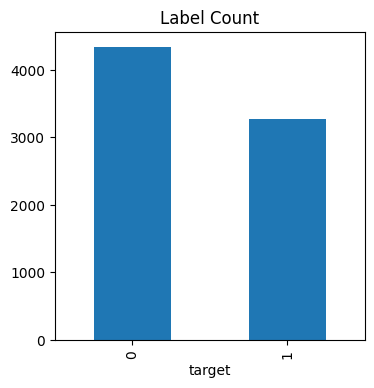

target
0    4342
1    3271
Name: count, dtype: int64


In [205]:
# Check Imbalanced

f, ax = plt.subplots(1, 1, figsize=(4, 4))
train['target'].value_counts().plot.bar(ax=ax)
ax.set_title('Label Count')
plt.show()
print(train['target'].value_counts())

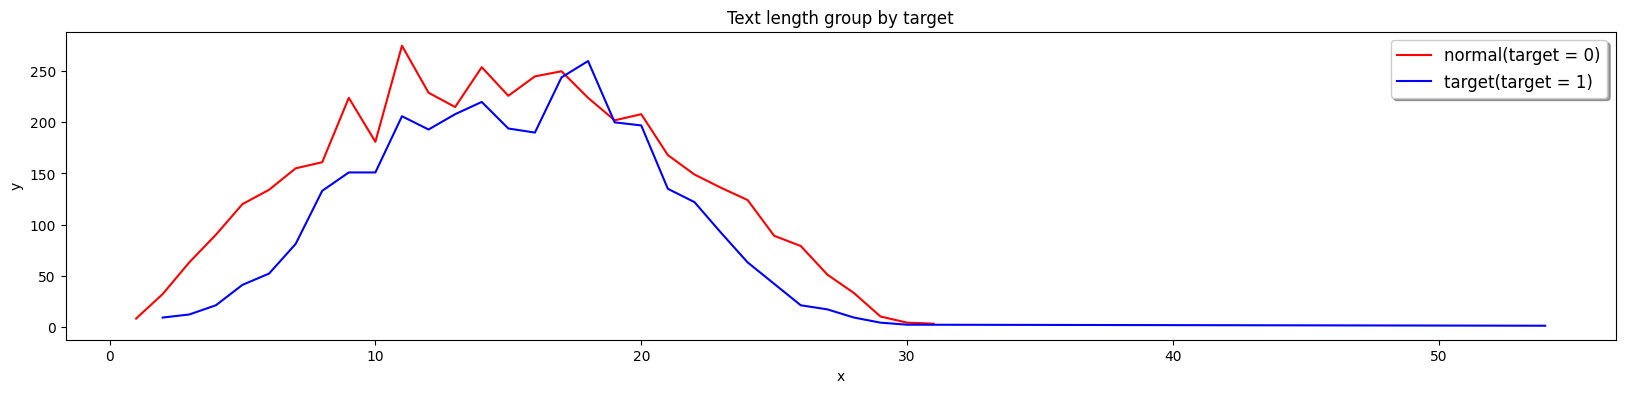

In [206]:
# Text length group by target

normal_df = train[train['target'] == 0]['message_len'].value_counts().sort_index()
target_df = train[train['target'] == 1]['message_len'].value_counts().sort_index()


plt.figure(figsize=(20, 4))
plt.plot(normal_df.index, normal_df.values, label = 'normal(target = 0)', color = 'red')
plt.plot(target_df.index, target_df.values, label = 'target(target = 1)', color = 'blue')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Text length group by target")
plt.legend(ncol=1, fontsize = 12, frameon = True, shadow = True)
plt.show()

### Split Train/Validation dataset

In [207]:
train = train.iloc[:,:2]

In [208]:
train_df, valid_df = train_test_split(train)

In [209]:
train_df.head()

,id,text
5140,7330,finnish nuclear plant to move ahead after fina...
6728,9642,strong thunderstorm 4 miles east of pickens mo...
5684,8111,funds needed for rescued then abandoned cocker...
6069,8669,sinkhole swallows brooklyn intersection ûò vi...
7235,10361,jamesmelville some old testimony of weapons us...


In [210]:
valid_df.head()

,id,text
6528,9338,if i survive i'll see you tomorrow
3613,5157,11-year-old boy charged with manslaughter of t...
4459,6342,sinjar massacre yazidis blast lack of action o...
7471,10688,season 3 of new girl was such a emotional trai...
1334,1927,louis_tomlinson incredible? the children were ...


### Preprocessing to classification

In [211]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


We will first create a list called field, where the elements will be a tuple of string (name) and Field object. The Field object for the text should be placed with name 'text' and the object for label should be placed with name 'label'

In [212]:
# TEXT = data.Field(tokenize = 'revtok', include_lengths = True)
# LABEL = data.LabelField(dtype = torch.float)


TEXT = data.Field(sequential=True,
                      lower=True,
                      include_lengths=True,
                      batch_first=True,
                      fix_length=25)
LABEL = data.Field(use_vocab=True,
                       sequential=False,
                       dtype=torch.float16)
ID = data.Field(use_vocab=False,
                    sequential=False,
                    dtype=torch.float16)

In [213]:
# fields = [('text',TEXT), ('label',LABEL)]

# train_ds, val_ds, test_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df, test_df=test)

In [214]:
import os

def prepare_csv(df_train, df_test, seed=27, val_ratio=0.3):
    idx = np.arange(df_train.shape[0])

    np.random.seed(seed)
    np.random.shuffle(idx)

    val_size = int(len(idx) * val_ratio)

    df_train.iloc[idx[val_size:], :][['id', 'target', 'text']].to_csv(
        '/content/dataset_train.csv', index=False
    )

    df_train.iloc[idx[:val_size], :][['id', 'target', 'text']].to_csv(
        '/content/dataset_val.csv', index=False
    )

    df_test[['id', 'text']].to_csv('/content/dataset_test.csv',
                   index=False)

In [215]:
prepare_csv(train, test)


KeyError: "['target'] not in index"

In [180]:
train_temp, val_temp = data.TabularDataset.splits(
        path='/content/', format='csv', skip_header=True,
        train='dataset_train.csv', validation='dataset_val.csv',
        fields=[
            ('id', ID),
            ('target', LABEL),
            ('text', TEXT)
        ]
    )

test_temp = data.TabularDataset(
        path='/content/dataset_test.csv', format='csv',
        skip_header=True,
        fields=[
            ('id', ID),
            ('text', TEXT)
        ]
    )

In [88]:
# Lets look at a random example
print(vars(train_ds[15]))

# Check the type
print(type(train_ds[15]))

{'text': [' todd ', '_', ' calfee ', ' so ', ' mattburgener ', ' wanted ', ' to ', ' see ', ' that ', ' info ', ' on ', ' blight ', ' u ', ' got '], 'label': 1}
<class 'torchtext.data.example.Example'>


We will now build the vocabulary using only the training dataset. This can be accessed through TEXT.vocab and will be shared by the validation dataset.

We will use pretrainied 200 dimensional vectors to represent the tokens. Any unknown token will have a zero vector. These vectors will be later loaded as the embedding layer.

In [136]:
# MAX_VOCAB_SIZE = 25000

# TEXT.build_vocab(train_ds,
#                  max_size = MAX_VOCAB_SIZE,
#                  vectors = 'glove.6B.200d',
#                  unk_init = torch.Tensor.zero_)

In [137]:
# LABEL.build_vocab(train_ds)

In [181]:
TEXT.build_vocab(
        train_temp, val_temp, test_temp,
        max_size=20000,
        min_freq=10,
        vectors='glove.6B.200d'  # We use it for getting vocabulary of words
    )
LABEL.build_vocab(
        train_temp
    )
ID.build_vocab(
        train_temp, val_temp, test_temp
    )

In [182]:
def get_iterator(dataset, batch_size, train=True,
                 shuffle=True, repeat=False):

    device = torch.device('cuda:0' if torch.cuda.is_available()
                          else 'cpu')

    dataset_iter = data.Iterator(
        dataset, batch_size=batch_size, device=device,
        train=train, shuffle=shuffle, repeat=repeat,
        sort=False
    )

    return dataset_iter

In [183]:
# build iterator

# BATCH_SIZE = 128

# train_iterator, valid_iterator = data.BucketIterator.splits(
#     (train_ds, val_ds),
#     batch_size = BATCH_SIZE,
#     sort_within_batch = True,
#     device = device)

vocab_size = len(TEXT.vocab)

train_iter = get_iterator(train_temp, batch_size=32,
                          train=True, shuffle=True,
                          repeat=False)
val_iter = get_iterator(val_temp, batch_size=32,
                        train=True, shuffle=True,
                        repeat=False)
test_iter = get_iterator(test_temp, batch_size=32,
                          train=False, shuffle=False,
                          repeat=False)

In [185]:
# for test in test_iter:
#   print(test)

# # Lets look at a random example
# print(vars(test_temp[0]))

# # Check the type
# print(type(test_temp[0]))

{'id': '0', 'text': ['just', 'happened', 'a', 'terrible', 'car', 'crash']}
<class 'torchtext.data.example.Example'>


### 3. Model building and training
### LSTM architecture

In [186]:
# Hyperparameters
num_epochs = 30
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

Setting up the LSTM model

In [112]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):

        embedded = self.embedding(text)

        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))

        return output

In [187]:
#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

loading the pretrained vectors into the embedding matrix.

In [188]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([1988, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0715,  0.0935,  0.0237,  ...,  0.3362,  0.0306,  0.2558],
        ...,
        [ 0.5857, -0.2036, -0.0694,  ..., -0.3254,  0.0030, -0.0734],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0355, -0.5269, -0.3296,  ..., -0.3895,  0.2131,  0.5377]])

In [189]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0715,  0.0935,  0.0237,  ...,  0.3362,  0.0306,  0.2558],
        ...,
        [ 0.5857, -0.2036, -0.0694,  ..., -0.3254,  0.0030, -0.0734],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0355, -0.5269, -0.3296,  ..., -0.3895,  0.2131,  0.5377]])


In [190]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [117]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

#### Model training

In [192]:
# training function
def train(model, iterator):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:
        text, text_lengths = batch.text

        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()


    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [193]:
def evaluate(model, iterator):

    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)

            epoch_acc += acc.item()

    return epoch_acc / len(iterator)

In [194]:
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

print(f'time:{time.time()-t:.3f}')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### 4. Result
#### Model evaluation
Loss & Accuracy Plot

<function matplotlib.pyplot.show(close=None, block=None)>

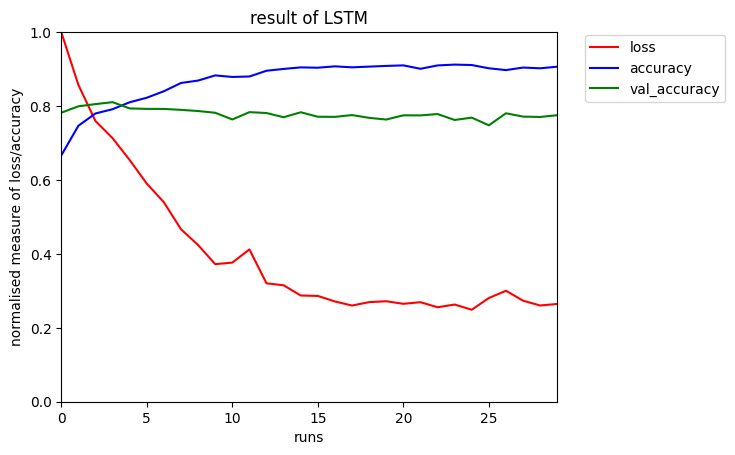

In [121]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, color = 'red',label="loss")
plt.plot(x_len, acc, color = 'blue', label="accuracy")
plt.plot(x_len, val_acc, color = 'green', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

Inference and create submission.csv

In [122]:
from tqdm import tqdm

results_target = list()

with torch.no_grad():
    for batch in tqdm(test_iter):
        for text, idx in zip(batch.text[0], batch.id):
            text = text.unsqueeze(0)
            res, _ = model(text, hidden=None)

            target = np.round(res.cpu().numpy())

            results_target.append(target[0][1])

  0%|          | 0/26 [00:00<?, ?it/s]


KeyError: None

### 5. Conclusion

Using LSTM, the model was learned lightly about 30 epochs. Even with a small amount of learning, the loss was sufficiently reduced, and the acuity increased a lot. There was a problem because the support of torchtext was stopped in the part of applying the tokenizer.
<br>

##### Additional Considerations
1. Using another Tokenizer, such as NLTK
2. Using a better model like BERT
3. Better architecture configuration